<center><img src="https://media-exp1.licdn.com/dms/image/C4E22AQEbIXZiRVkJPQ/feedshare-shrink_2048_1536/0?e=1591228800&v=beta&t=4uXLGuPLZdw16VZmiqkPdu57s6oSUWT-advRTvwzp5Q" width="1000"></center>

# SDC Certified Program in Python for Data Science

## Autor: Smit Jonatan Villafranca Romero

Link de la data: https://www.dropbox.com/sh/3s7j40jia09t09b/AABifaGQHpQHw4mM55tW9gpja?dl=0

## Información del conjunto de datos

Hay una falta de conjuntos de datos públicos disponibles sobre servicios financieros y especialmente en el dominio emergente de transacciones de dinero móvil. Los conjuntos de datos financieros son importantes para muchos investigadores y, en particular, para nosotros que realizamos investigaciones en el ámbito de la detección de fraudes. Parte del problema es la naturaleza intrínsecamente privada de las transacciones financieras, que no lleva a conjuntos de datos disponibles públicamente.

Presentamos un conjunto de datos sintéticos generado utilizando el simulador llamado PaySim como un enfoque para tal problema. PaySim utiliza datos agregados del conjunto de datos privado para generar un conjunto de datos sintético que se asemeja al funcionamiento normal de las transacciones e inyecta un comportamiento malicioso para luego evaluar el rendimiento de los métodos de detección de fraude.

## Información de los atributos:

Variables de entrada :

1. steep(tipo) - EFECTIVO, EFECTIVO, DÉBITO, PAGO y TRANSFERENCIA.

2. amount(cantidad) -monto de la transacción en moneda local.

3. nameOrig: cliente que inició la transacción

4. oldbalanceOrg - saldo inicial antes de la transacción

5. newbalanceOrig - nuevo saldo después de la transacción

6. nameDest - cliente que es el destinatario de la transacción

7. oldbalanceDest: destinatario del saldo inicial antes de la transacción. Tenga en cuenta que no hay información para los clientes que comienzan con M (Comerciantes).

8. newbalanceDest: nuevo destinatario del saldo después de la transacción. Tenga en cuenta que no hay información para los clientes que comienzan con M (Comerciantes).


9. isFlaggedFraud: el modelo de negocio tiene como objetivo controlar transferencias masivas de una cuenta a otra y señala intentos ilegales. Un intento ilegal en este conjunto de datos es un intento de transferir más de 200,000 en una sola transacción.

Variable de salida:

10. isFraud: son las transacciones realizadas por los agentes fraudulentos dentro de la simulación. En este conjunto de datos específico, el comportamiento fraudulento de los agentes apunta a obtener ganancias tomando el control de las cuentas de los clientes e intentando vaciar los fondos transfiriéndolos a otra cuenta y luego retirando del sistema.


In [1]:
#Instalando las librerías necesarias
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import model_evaluation_utils as meu

from collections import defaultdict                    #Para diccionarios por defecto        
from imblearn.under_sampling import RandomUnderSampler #Para balanceo de datos
from sklearn.preprocessing import label_binarize       #Para binarizar variables
from sklearn.preprocessing import LabelEncoder         #Para codificar variables
from sklearn.preprocessing import KBinsDiscretizer     #Para discretizar variables
from sklearn.model_selection import train_test_split   #Particionamiento de datos
from sklearn.model_selection import cross_val_score    #Efectuar cross validation (Validación Cruzada)
from sklearn.metrics import confusion_matrix           #Para obtener la matriz de confusión
from sklearn.metrics import roc_curve, auc             #Para obtener la curva roc y el área bajo la curva
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier    #Para hacer un modelo de Random Forest
from sklearn.naive_bayes import GaussianNB             #Para hacer un modelo de Naive-Bayes
from sklearn.svm import SVC                            #Para hacer un modelo de SVM
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator #Para modelos de Redes Neuronales

from sklearn.model_selection import GridSearchCV       #Para optimización de parámetros
from sklearn import tree
from mlxtend.plotting import plot_decision_regions     #Para generar regiones de decisiones
from graphviz import Source
from subprocess import check_call
from sklearn import metrics

from joblib import dump #Para despliegue de modelos
from joblib import load #Para despliegue de modelos

#Just in Case
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

In [2]:
os.chdir(r"E:\PYTHON\MODULO 3-AVANZADO\EXAMEN FINAL")
bank = pd.read_csv('PS_20174392719_1491204439457_log.csv')
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [3]:
bank.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [4]:
#Veamos las frecuencias de la variable type
pd.value_counts(bank.type)

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

## Actividades

Nota: No considerar las siguientes variables 'step', 'nameOrig', 'nameDest', 'isFlaggedFraud' para el examen.

PYTHON>

1.	Dividir los datos para el entrenamiento y testeo en una proporción de 70 y 30, respectivamente. (2 pts.)
2.	Aplicar balanceo de datos under-sampling, fijando como parámetro 0.8. (2 pts.)
3.	Implementar el modelo de árboles de decisión a los datos de entrenamiento. (2 pts.)
4.  Implementar el modelo de random forest a los datos de entrenamiento. (2 pts.)
5.  Implementar el modelo de naive bayes a los datos de entrenamiento. (2 pts.)
6.  Implementar el modelo de redes neuronales a los datos de entrenamiento. (2 pts.)
7.  haciendo uso de las métricas de accuracy, sensibilidad. especificidad, auc y curva ROC evaluar los modelos generados (train y test) y realizar un análisis. (5 pts.)
8.	Desplegar el modelo haciendo uso de H2O mediante Dash. (3 pts.)

Nota: considerar en códigos que requieran de semilla el valor de 2020.

In [5]:
#Elinando las columna que no vamos a trabajar
columnas=['step', 'nameOrig', 'nameDest', 'isFlaggedFraud']
nueva_bank=bank.drop(columnas,axis=1)
nueva_bank.head(5)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [6]:
#Transfotmamos la columna "type" de tipo objeto a entero
encoder = LabelEncoder()
nueva_bank["type"] = encoder.fit_transform(nueva_bank["type"])

In [7]:
pd.value_counts(nueva_bank.type)

1    2237500
3    2151495
0    1399284
4     532909
2      41432
Name: type, dtype: int64

In [8]:
print('Las variables transformadas se almacenan en los siguientes valores')
print('...............A) CASH_IN  = 0...............')
print('...............B) CASH_OUT = 1...............')
print('...............C) DEBIT    = 2...............')
print('...............D) PAYMENT  = 3...............')
print('...............E) TRANSFER = 4...............')

Las variables transformadas se almacenan en los siguientes valores
...............A) CASH_IN  = 0...............
...............B) CASH_OUT = 1...............
...............C) DEBIT    = 2...............
...............D) PAYMENT  = 3...............
...............E) TRANSFER = 4...............


In [9]:
#Mostramos los datos transformados
nueva_bank.head(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,3,9839.64,170136.00,160296.36,0.0,0.00,0
1,3,1864.28,21249.00,19384.72,0.0,0.00,0
2,4,181.00,181.00,0.00,0.0,0.00,1
3,1,181.00,181.00,0.00,21182.0,0.00,1
4,3,11668.14,41554.00,29885.86,0.0,0.00,0
5,3,7817.71,53860.00,46042.29,0.0,0.00,0
6,3,7107.77,183195.00,176087.23,0.0,0.00,0
7,3,7861.64,176087.23,168225.59,0.0,0.00,0
8,3,4024.36,2671.00,0.00,0.0,0.00,0
9,2,5337.77,41720.00,36382.23,41898.0,40348.79,0


### _1.  Dividir los datos para el entrenamiento y testeo en una proporción de 70 y 30, respectivamente._

In [10]:
#Dividimos la variables de entrenamiento y nuestra Target
x = nueva_bank.drop(columns="isFraud")
y = nueva_bank["isFraud"]

In [11]:
#Mostramos nuestras variables predictoras(X)
x.head(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,3,9839.64,170136.00,160296.36,0.0,0.00
1,3,1864.28,21249.00,19384.72,0.0,0.00
2,4,181.00,181.00,0.00,0.0,0.00
3,1,181.00,181.00,0.00,21182.0,0.00
4,3,11668.14,41554.00,29885.86,0.0,0.00
5,3,7817.71,53860.00,46042.29,0.0,0.00
6,3,7107.77,183195.00,176087.23,0.0,0.00
7,3,7861.64,176087.23,168225.59,0.0,0.00
8,3,4024.36,2671.00,0.00,0.0,0.00
9,2,5337.77,41720.00,36382.23,41898.0,40348.79


In [12]:
#Mostramos nuestra target(Y)
y.head(10)

0    0
1    0
2    1
3    1
4    0
5    0
6    0
7    0
8    0
9    0
Name: isFraud, dtype: int64

In [13]:
#Particionamos nuestros datos
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2020)

In [14]:
#Mostramos las datos de entrenamiento(x_train)
x_train.head(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
3334185,1,178588.68,11112.0,0.00,281459.11,460047.79
1063102,1,541677.69,0.0,0.00,1162774.10,1704451.79
2877603,3,4047.19,94282.0,90234.81,0.00,0.00
1661392,1,29408.22,438.0,0.00,0.00,29408.22
3416508,3,7381.62,0.0,0.00,0.00,0.00
3615120,1,282577.27,101878.0,0.00,39449.58,322026.85
212130,1,63797.09,0.0,0.00,666843.65,730640.74
2654419,4,249089.02,21757.0,0.00,0.00,249089.02
2081859,3,6421.38,0.0,0.00,0.00,0.00
2893198,1,146088.66,0.0,0.00,375010.30,521098.96


In [15]:
print('La cantidad de filas de la data de entrenamiento(x_train) es: ',len(x_train))

La cantidad de filas de la data de entrenamiento(x_train) es:  4453834


In [16]:
#Mostramos las datos de testeo(x_test)
x_test.head(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
3168702,0,274151.34,1201618.40,1475769.74,2679286.53,2405135.19
756524,1,299948.58,0.00,0.00,510398.34,719824.99
5532791,3,14999.59,391034.00,376034.41,0.00,0.00
5449747,0,192634.60,8195355.25,8387989.85,376096.90,183462.30
2636978,1,125667.58,0.00,0.00,1037732.69,1163400.27
1847529,3,556.71,106.00,0.00,0.00,0.00
355286,1,122313.62,83140.14,0.00,5607181.60,5729495.21
894602,0,17234.66,5489.00,22723.66,8078678.77,8061444.11
5947838,3,932.13,0.00,0.00,0.00,0.00
2640079,1,112821.81,10577.00,0.00,5654.94,118476.75


In [17]:
print('La cantidad de filas de la data de testeo(x_test) es: ',len(x_test))

La cantidad de filas de la data de testeo(x_test) es:  1908786


### _2. Aplicar balanceo de datos under-sampling, fijando como parámetro 0.8._

#### _Antes delbalanceo_

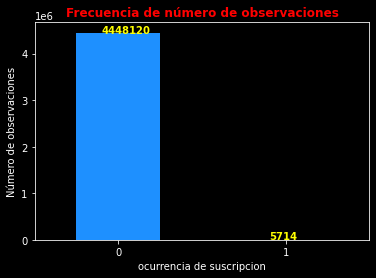

In [18]:
%matplotlib inline
colores  = ("dodgerblue","salmon", "palevioletred", 
           "steelblue", "seagreen", "plum", 
           "blue", "indigo", "beige", "yellow")
with plt.style.context('dark_background'):
  count_classes = pd.value_counts(y_train, sort = True)
  count_classes.plot(kind = 'bar', rot=0,color=colores)
plt.xticks(range(2))
plt.title("Frecuencia de número de observaciones",weight='bold',color='red')
plt.xlabel("ocurrencia de suscripcion")
plt.ylabel("Número de observaciones")
plt.text(-0.1,4448120,"4448120",weight="bold",color="yellow")
plt.text(0.9,5714,"5714",weight="bold",color="yellow")
warnings.filterwarnings('ignore')

In [19]:
pd.value_counts(y_train)

0    4448120
1       5714
Name: isFraud, dtype: int64

#### _Después del balanceo_

In [20]:
#Hacemos el balanceo de los datos usando UnderSampler
UnderSampler=RandomUnderSampler(sampling_strategy=0.8,random_state=2020)
x_train_UnderSampler,y_train_UnderSampler=UnderSampler.fit_resample(x_train,y_train)

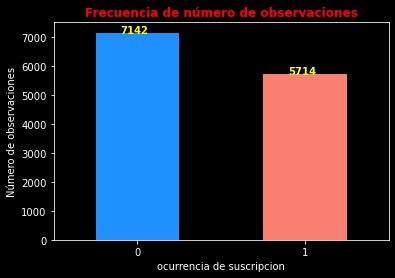

In [21]:
%matplotlib inline
with plt.style.context('dark_background'):
    count_classes = pd.value_counts(y_train_UnderSampler, sort = True)
    count_classes.plot(kind = 'bar', rot=0,color=colores)
plt.xticks(range(2))
plt.title("Frecuencia de número de observaciones",weight='bold',color='red')
plt.xlabel("ocurrencia de suscripcion")
plt.ylabel("Número de observaciones")
plt.text(-0.1,7142,"7142",weight="bold",color="yellow")
plt.text(0.9,5714,"5714",weight="bold",color="yellow")
warnings.filterwarnings('ignore')

In [22]:
pd.value_counts(y_train_UnderSampler)

0    7142
1    5714
Name: isFraud, dtype: int64

In [23]:
len(x_train_UnderSampler)

12856

### _3. Implementar el modelo de árboles de decisión a los datos de entrenamiento._

In [24]:
#Instanciando un objeto de clase DecisionTreeClassifier
Arbol_decision=DecisionTreeClassifier(max_depth=4) #(Por default trabaja con GINI)
Arbol_decision

DecisionTreeClassifier(max_depth=4)

In [25]:
#Hacer que aprenda de los datos de entrenamiento
Arbol_decision=Arbol_decision.fit(x_train_UnderSampler,y_train_UnderSampler)

In [26]:
#Mostrando la Importancia de las Características o Variables Predictoras
importancia=Arbol_decision.feature_importances_
print(importancia)

[0.03554629 0.08157561 0.35753158 0.44890952 0.         0.076437  ]


In [27]:
#Creamos 
predictores=['type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

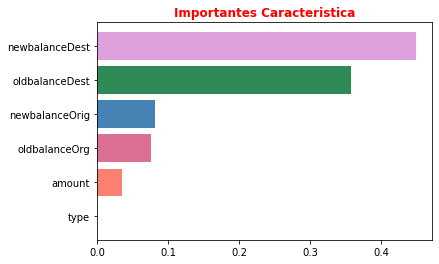

In [28]:
#Visualizando las Variables Importantes
importancia= Arbol_decision.feature_importances_
indices=np.argsort(importancia)
p=x_train.shape[1]

plt.title("Importantes Caracteristica",weight='bold',color='red')
plt.barh(range(p),importancia[indices],color=colores)
plt.yticks(range(p),predictores)
plt.show()

**Graficando el modelo de Árbol de Decisión**

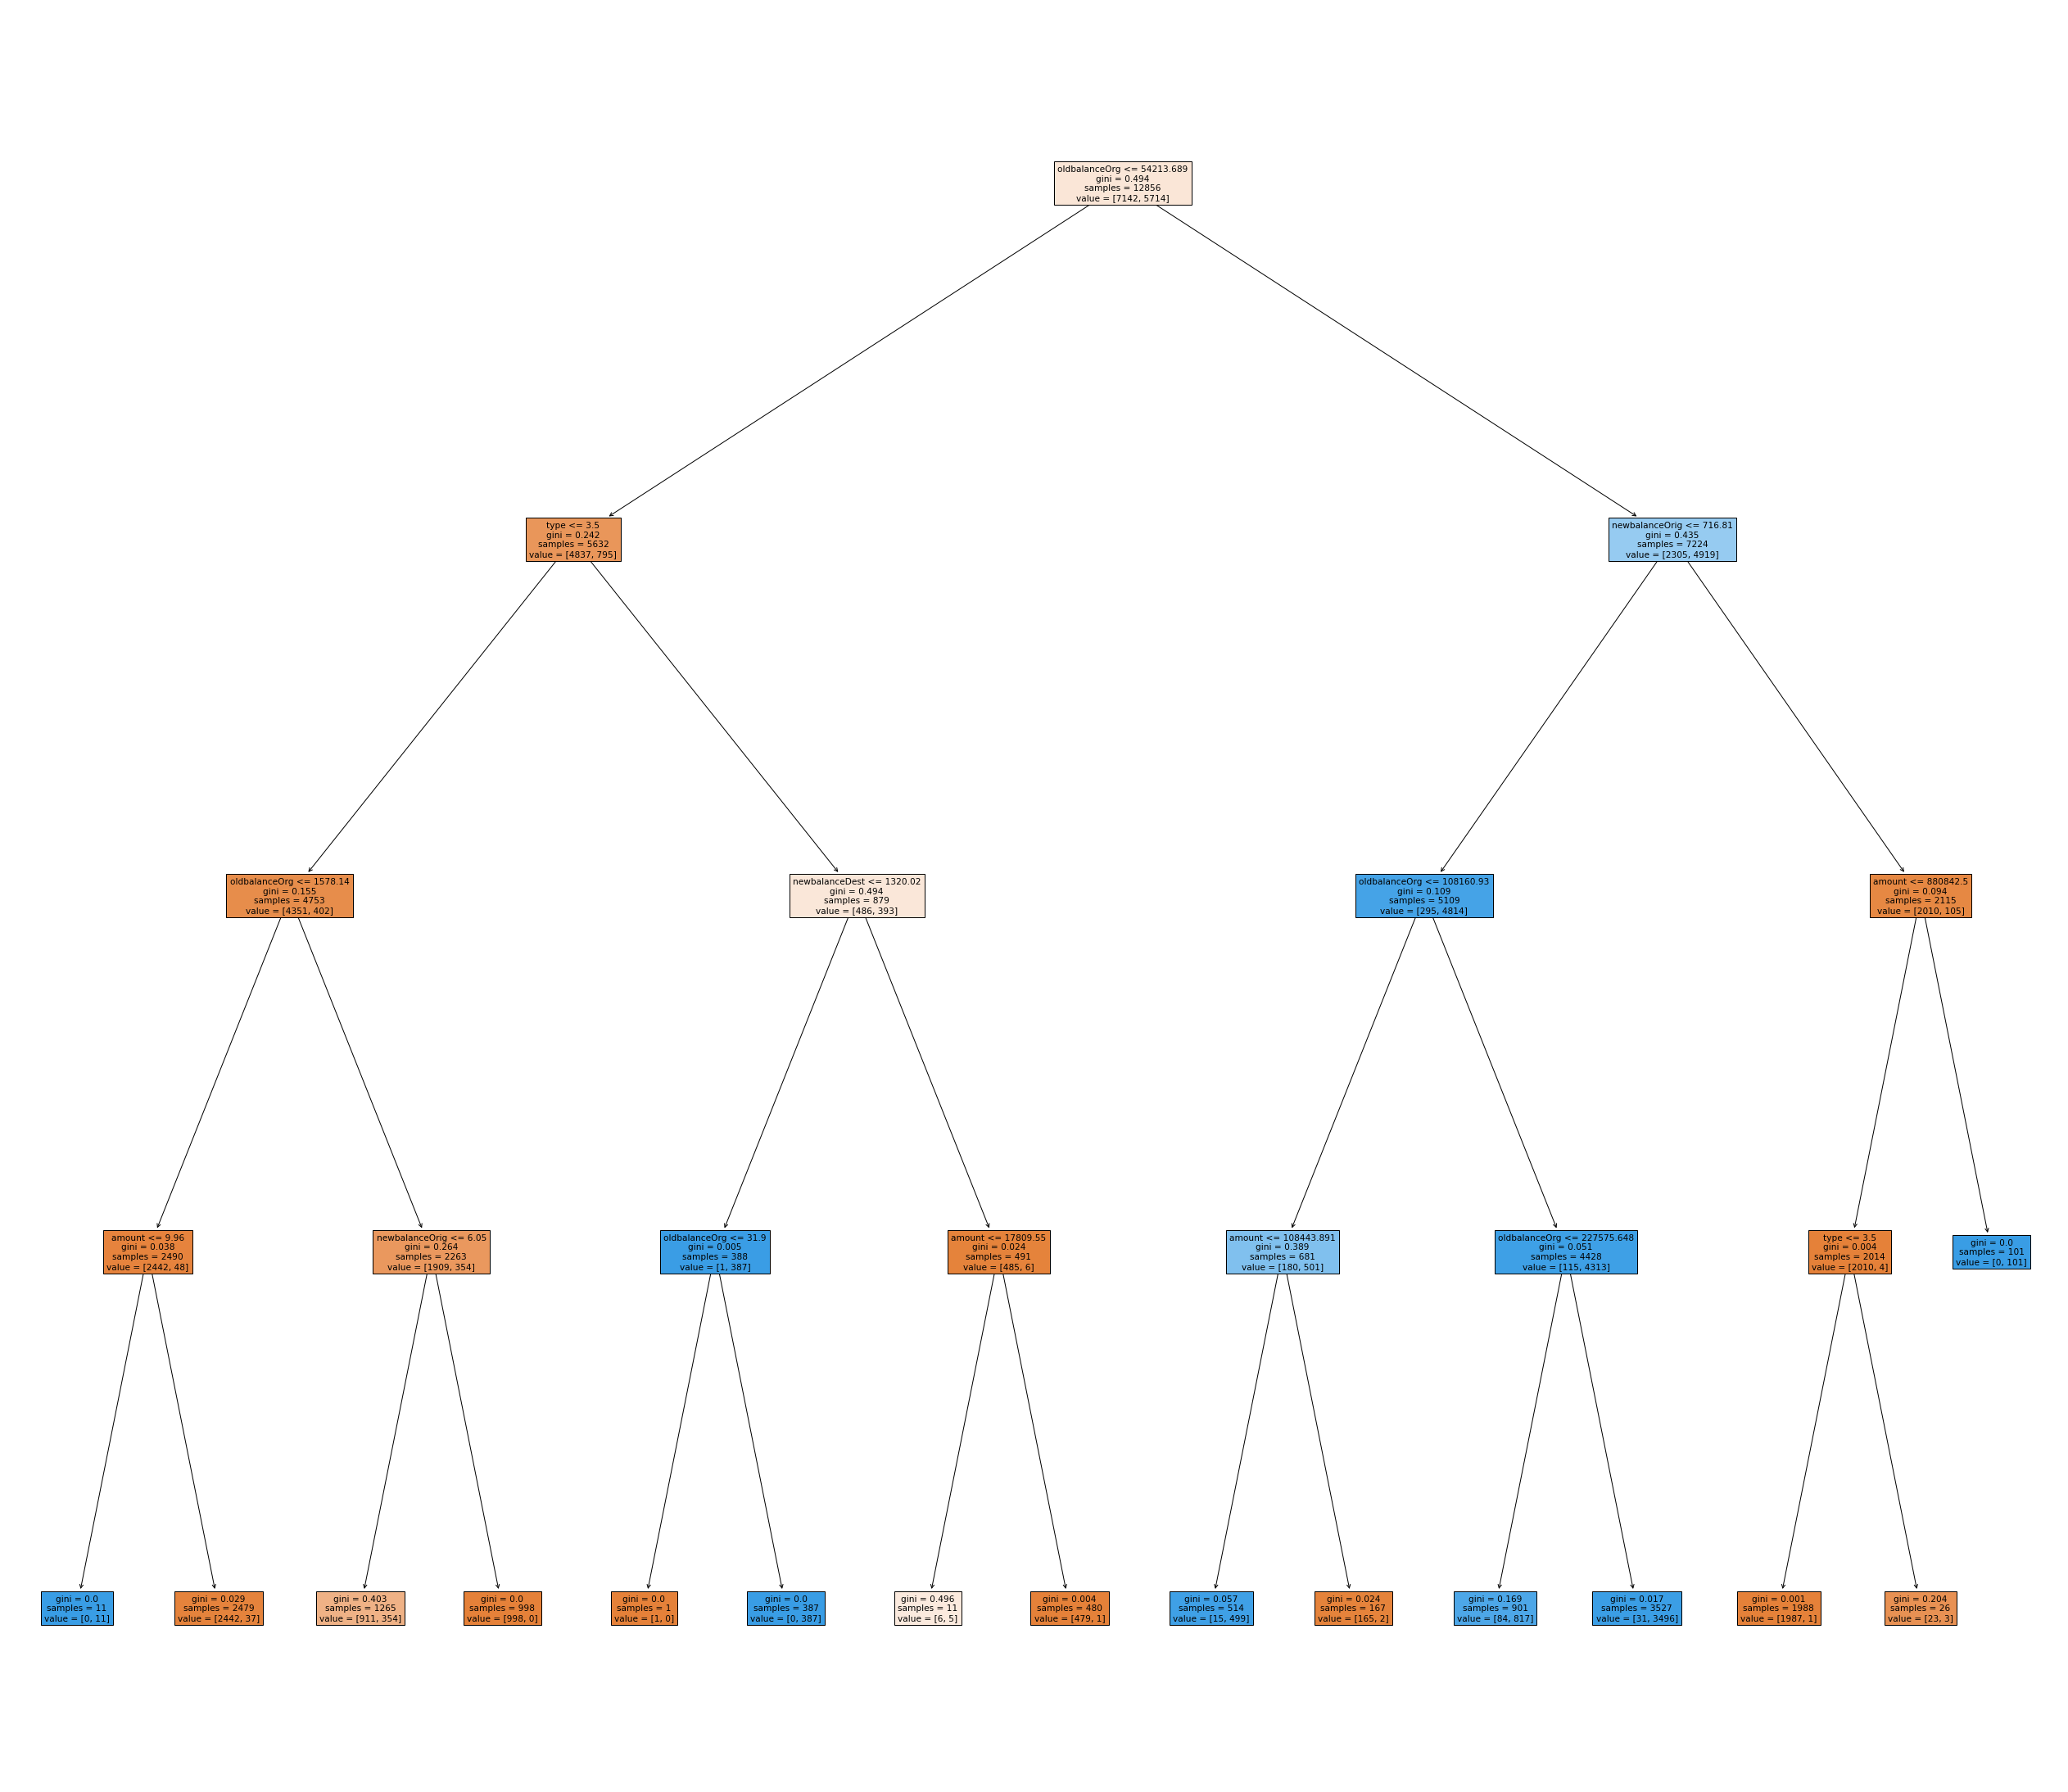

In [29]:
#Establecemos un tamaño grande visualmente hablando
fig=plt.figure(figsize=(45,40))
#Ploteamos el árbol de decisión
_=plot_tree(decision_tree= Arbol_decision, feature_names=predictores,filled=True)

**Visualizando los puntosde corte de los  nodos**

In [30]:
text_representation= tree.export_text(decision_tree=Arbol_decision,feature_names=predictores)
print(text_representation)

|--- oldbalanceOrg <= 54213.69
|   |--- type <= 3.50
|   |   |--- oldbalanceOrg <= 1578.14
|   |   |   |--- amount <= 9.96
|   |   |   |   |--- class: 1
|   |   |   |--- amount >  9.96
|   |   |   |   |--- class: 0
|   |   |--- oldbalanceOrg >  1578.14
|   |   |   |--- newbalanceOrig <= 6.05
|   |   |   |   |--- class: 0
|   |   |   |--- newbalanceOrig >  6.05
|   |   |   |   |--- class: 0
|   |--- type >  3.50
|   |   |--- newbalanceDest <= 1320.02
|   |   |   |--- oldbalanceOrg <= 31.90
|   |   |   |   |--- class: 0
|   |   |   |--- oldbalanceOrg >  31.90
|   |   |   |   |--- class: 1
|   |   |--- newbalanceDest >  1320.02
|   |   |   |--- amount <= 17809.55
|   |   |   |   |--- class: 0
|   |   |   |--- amount >  17809.55
|   |   |   |   |--- class: 0
|--- oldbalanceOrg >  54213.69
|   |--- newbalanceOrig <= 716.81
|   |   |--- oldbalanceOrg <= 108160.93
|   |   |   |--- amount <= 108443.89
|   |   |   |   |--- class: 1
|   |   |   |--- amount >  108443.89
|   |   |   |   |--- class

#### _Métricas de evaluación de modelos para datos de entrenamiento y testeo_

In [31]:
probs2 = Arbol_decision.predict(x_test)#datos de testeo
#predict(): función para calcular los valores predichos
probs2

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [32]:
probs = Arbol_decision.predict(x_train_UnderSampler)
#predict(): función para calcular los valores predichos
probs

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [33]:
metrics.accuracy_score(y_test, probs2)

0.9801088230948886

In [34]:
metrics.accuracy_score(y_train_UnderSampler, probs)

0.9585407591785936

In [35]:
from sklearn.metrics import accuracy_score

In [36]:
#Matriz de Confusion para la variablede testeo
matriz=confusion_matrix(y_test,probs2)
print(matriz)

[[1868487   37800]
 [    168    2331]]


In [37]:
#Matriz de Confusion para la variable de entrenamiento
matriz=confusion_matrix(y_train_UnderSampler, probs)
print(matriz)

[[7012  130]
 [ 403 5311]]


In [38]:
#TESTEO
accuracy=accuracy_score(y_test,probs2)
print(accuracy)

0.9801088230948886


In [39]:
score= cross_val_score(Arbol_decision, #estimator
                      x_train_UnderSampler,
                      y_train_UnderSampler,
                      scoring='accuracy', #Métrica o estrategia de evaluación
                      cv=10) #Número de Particiones para la evaluación
score

array([0.94867807, 0.96345257, 0.95178849, 0.95412131, 0.96189736,
       0.95956454, 0.95252918, 0.9618677 , 0.96575875, 0.96031128])

In [40]:
score.mean()

0.9579969258884968

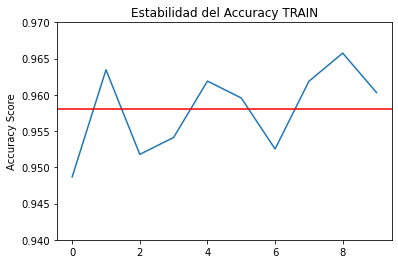

In [41]:
#Analizando visualmente la estabilidad de la métrica
plt.plot(range(0,10),score)
plt.title('Estabilidad del Accuracy TRAIN')
plt.ylabel('Accuracy Score')
plt.axhline(y=score.mean(),color="red") #Línea referencial
plt.ylim([0.94,0.97]) #Modificando los límites del eje Y
plt.show()

In [42]:
score= cross_val_score(Arbol_decision, #estimator
                      x_test,
                      y_test,
                      scoring='accuracy', #Métrica o estrategia de evaluación
                      cv=10) #Número de Particiones para la evaluación
score

array([0.9995285 , 0.99955469, 0.99929798, 0.99929275, 0.99955993,
       0.99921416, 0.99930846, 0.99934513, 0.99936609, 0.99939752])

In [43]:
score.mean()

0.999386520998747

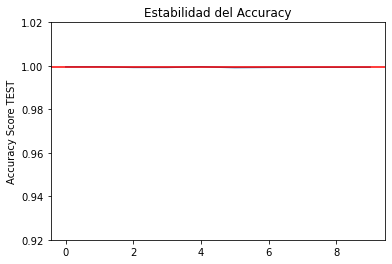

In [44]:
#Analizando visualmente la estabilidad de la métrica
plt.plot(range(0,10),score)
plt.title('Estabilidad del Accuracy')
plt.ylabel('Accuracy Score TEST')
plt.axhline(y=score.mean(),color="red") #Línea referencial
plt.ylim([0.92,1.02]) #Modificando los límites del eje Y
plt.show()

### _4. Implementar el modelo de random forest a los datos de entrenamiento._

In [45]:
#Visualicemos las frecuencias de la columna isFraud
pd.value_counts(nueva_bank.isFraud)

0    6354407
1       8213
Name: isFraud, dtype: int64

In [46]:
#Veamos la informacion de nuestra data
nueva_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            int32  
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   oldbalanceDest  float64
 5   newbalanceDest  float64
 6   isFraud         int64  
dtypes: float64(5), int32(1), int64(1)
memory usage: 315.5 MB


In [47]:
#Se necesita tener cuidado con el formato de la target en h2o
nueva_bank=nueva_bank.astype({"isFraud":"object"})
nueva_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            int32  
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   oldbalanceDest  float64
 5   newbalanceDest  float64
 6   isFraud         object 
dtypes: float64(5), int32(1), object(1)
memory usage: 315.5+ MB


In [48]:
#Recodificando nuestra variable target
nueva_bank.isFraud=nueva_bank.isFraud.replace(1,'si')
nueva_bank.isFraud=nueva_bank.isFraud.replace(0,'no')

In [49]:
#Revisando la cabecera de los datos
nueva_bank.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,3,9839.64,170136.0,160296.36,0.0,0.0,no
1,3,1864.28,21249.0,19384.72,0.0,0.0,no
2,4,181.00,181.0,0.00,0.0,0.0,si
3,1,181.00,181.0,0.00,21182.0,0.0,si
4,3,11668.14,41554.0,29885.86,0.0,0.0,no


In [50]:
print('Cantidad de registros',len(nueva_bank))

Cantidad de registros 6362620


In [51]:
#Alcenando los nommbres de las variables, predictores y target
colnames=nueva_bank.columns.tolist()
predictores=colnames[0:len(colnames)-1]
target=colnames[len(colnames)-1]

In [52]:
print('Las variables predictoras son: ', predictores)
print('Las variable target es:',target)

Las variables predictoras son:  ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
Las variable target es: isFraud


In [53]:
#Inicializando h2o
h2o.init(max_mem_size='4g')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from C:\ProgramData\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\user\AppData\Local\Temp\tmpa94jkfz4
  JVM stdout: C:\Users\user\AppData\Local\Temp\tmpa94jkfz4\h2o_user_started_from_python.out
  JVM stderr: C:\Users\user\AppData\Local\Temp\tmpa94jkfz4\h2o_user_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Lima
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,1 month and 30 days
H2O_cluster_name:,H2O_from_python_user_n3iej9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"accepting new members, healthy"


In [54]:
#Convirtiendo un DF de Pandas a un objeto H2oFrame
bank_h2o_train=h2o.H2OFrame(nueva_bank)

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Random Fores

In [29]:
#Instanciando un objeto de clase H2ORandomForestEstimator
m= h2o.estimators.H2ORandomForestEstimator(nfolds=10,  #particiones de datos
                                          max_depth=3, #profundidad máxima de los árboles
                                          ntrees=50,   #número de árboles
                                          seed=2020)   #semilla

In [56]:
#Aprender de los datos de entrenamiento
m.train(x=predictores,
       y=target,
       training_frame=bank_h2o_train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


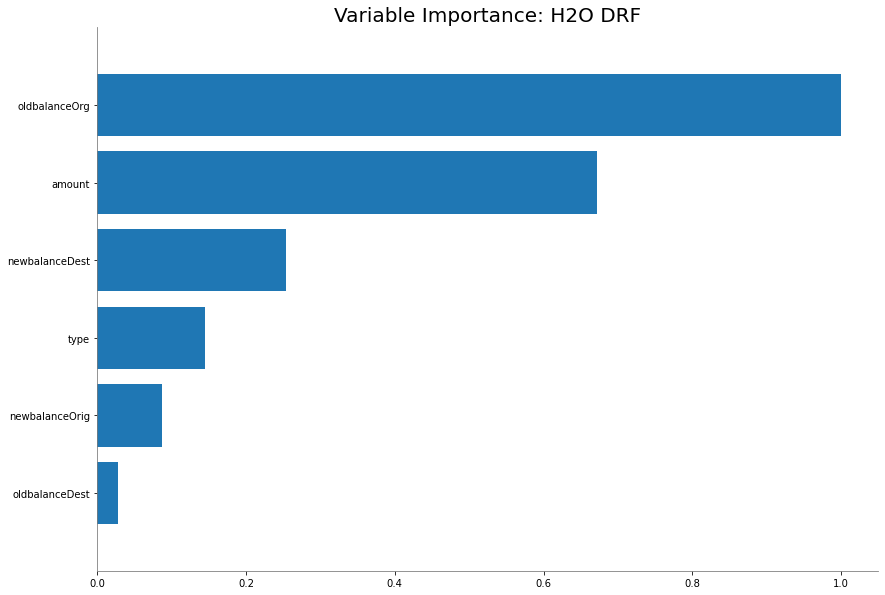

In [57]:
#Identificando las variables más importantes para nuestro modelo de RF
m.varimp_plot()

In [58]:
#Evaluar la performance del modelo con los datos de entrenamiento
performance_train= m.model_performance(bank_h2o_train)
performance_train


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.0009681565794545058
RMSE: 0.031115214597596877
LogLoss: 0.005451271948523809
Mean Per-Class Error: 0.09056122101047093
AUC: 0.9564375486672004
AUCPR: 0.5156335764071227
Gini: 0.9128750973344009

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08258996438980101: 


,,no,si,Error,Rate
0,no,6353409.0,999.0,0.0002,(999.0/6354408.0)
1,si,5049.0,3164.0,0.6148,(5049.0/8213.0)
2,Total,6358458.0,4163.0,0.001,(6048.0/6362621.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.082590,5.113122e-01,140.0
1,max f2,0.021050,6.062820e-01,216.0
2,max f0point5,0.178425,6.940663e-01,88.0
3,max accuracy,0.140405,9.991184e-01,103.0
4,max precision,0.785283,1.000000e+00,0.0
5,max recall,0.000594,1.000000e+00,378.0
6,max specificity,0.785283,1.000000e+00,0.0
7,max absolute_mcc,0.140405,5.647902e-01,103.0
8,max min_per_class_accuracy,0.002892,8.793376e-01,321.0
9,max mean_per_class_accuracy,0.002892,9.094388e-01,321.0



Gains/Lift Table: Avg response rate:  0.13 %, avg score:  0.13 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010032,0.006523,74.204120,74.204120,0.095784,0.036316,0.095784,0.036316,0.744430,0.744430,7320.411978,7320.411978,0.735347
1,2,0.020441,0.005734,0.081882,36.459961,0.000106,0.005878,0.047063,0.020816,0.000852,0.745282,-91.811759,3545.996108,0.725778
2,3,0.030277,0.005181,0.012379,24.619222,0.000016,0.005416,0.031779,0.015813,0.000122,0.745404,-98.762142,2361.922198,0.716051
3,4,0.040427,0.004004,0.035987,18.447131,0.000046,0.004481,0.023812,0.012968,0.000365,0.745769,-96.401258,1744.713123,0.706253
4,5,0.051703,0.003069,9.384100,16.470678,0.012113,0.003245,0.021261,0.010848,0.105808,0.851577,838.410019,1547.067834,0.800908
5,6,0.103861,0.001893,0.532242,8.466488,0.000687,0.002382,0.010929,0.006596,0.027761,0.879338,-46.775825,746.648766,0.776479
6,7,0.151781,0.001072,0.002541,5.794259,0.000003,0.001262,0.007479,0.004912,0.000122,0.879459,-99.745915,479.425925,0.728619
7,8,0.207155,0.000941,0.094550,4.270693,0.000122,0.000997,0.005513,0.003866,0.005236,0.884695,-90.544970,327.069345,0.678416
8,9,0.305449,0.000767,0.566089,3.078541,0.000731,0.000836,0.003974,0.002891,0.055643,0.940338,-43.391074,207.854059,0.635710
9,10,0.423321,0.000726,0.342946,2.316827,0.000443,0.000737,0.002991,0.002291,0.040424,0.980762,-65.705371,131.682697,0.558161


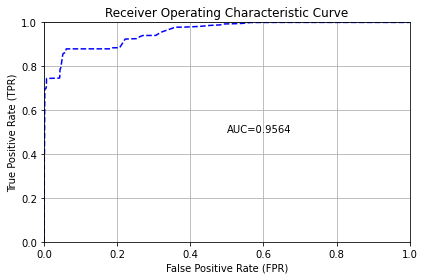

In [59]:
#Podemos obtener la curva ROC para la Data de Entrenamiento con su respectivo AUC
performance_train.plot(type='roc')

In [60]:
#Podemos obtener la Matriz de Confusión para la Data de Entrenamiento
performance_train.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08258996438980101: 


,,no,si,Error,Rate
0,no,6353409.0,999.0,0.0002,(999.0/6354408.0)
1,si,5049.0,3164.0,0.6148,(5049.0/8213.0)
2,Total,6358458.0,4163.0,0.001,(6048.0/6362621.0)


#### Hallando las probabilidades de Ypredicho

In [61]:
#Cálculo de probabilidades de predicción para la variable target (Data de Entrenamiento)
ypredicho_train=m.predict(bank_h2o_train)
ypredicho_train

drf prediction progress: |████████████████████████████████████████████████| 100%


predict,no,si
no,0.997772,0.00222771
no,0.999566,0.000433656
no,0.978958,0.0210416
no,0.999293,0.00070721
no,0.999406,0.000594434
no,0.999406,0.000594434
no,0.998107,0.00189279
no,0.997772,0.00222771
no,0.999421,0.000579426
no,0.999387,0.000613041


In [62]:
type(ypredicho_train)

h2o.frame.H2OFrame

In [63]:
#Convertir un objeto h2oFrame en un DataFrame de Pandas
ypredicho_train_pandas=h2o.as_list(ypredicho_train)
ypredicho_train_pandas.head()

,predict,no,si
0,no,0.997772,0.002228
1,no,0.999566,0.000434
2,no,0.978958,0.021042
3,no,0.999293,0.000707
4,no,0.999406,0.000594


In [64]:
type(ypredicho_train_pandas)

pandas.core.frame.DataFrame

In [65]:
len(ypredicho_train_pandas)

6362621

In [66]:
h2o.shutdown()

H2O session _sid_9597 closed.


### _5. Implementar el modelo de naive bayes a los datos de entrenamiento._

Al comienzo hicimos el balancio de los datos y tambien la división de los datos en variables predictoras y target, el cual creamos un listado.
Ahora se va a crear un DataFrame tanto para la predictora y target para luego unirlas a un nuevo DataFrame.

In [67]:
#Conviertiendo los datos de entrenamiento a DF
bank_x_us=pd.DataFrame(x_train_UnderSampler,columns=predictores)
bank_y_us=pd.DataFrame(y_train_UnderSampler,columns=[target])
bank_train=pd.concat([bank_x_us,bank_y_us],axis=1)
bank_train.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,151697.59,12992.00,0.00,906991.80,1058689.39,0
1,1,313304.95,26250.00,0.00,5721488.83,6034793.78,0
2,3,3026.14,18049.76,15023.62,0.00,0.00,0
3,3,18737.28,92612.00,73874.72,0.00,0.00,0
4,0,390976.21,3269067.53,3660043.74,1193520.26,802544.05,0


In [68]:
print('La cantidad de filas de la data "bank_train"',len(bank_train))

La cantidad de filas de la data "bank_train" 12856


In [69]:
#Conviertiendo los datos de teste a DF
bank_x_test=pd.DataFrame(x_test,columns=predictores)
bank_y_test=pd.DataFrame(y_test,columns=[target])
bank_test=pd.concat([bank_x_test,bank_y_test],axis=1)
bank_test.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
3168702,0,274151.34,1201618.40,1475769.74,2679286.53,2405135.19,0
756524,1,299948.58,0.00,0.00,510398.34,719824.99,0
5532791,3,14999.59,391034.00,376034.41,0.00,0.00,0
5449747,0,192634.60,8195355.25,8387989.85,376096.90,183462.30,0
2636978,1,125667.58,0.00,0.00,1037732.69,1163400.27,0


In [70]:
print('La cantidad de filas de la data "bank_train"',len(bank_test))

La cantidad de filas de la data "bank_train" 1908786


**naive bayes**

In [71]:
#Instanciamos un objeto de clase KBinsDiscretizer
bank_kmeans=KBinsDiscretizer(n_bins=3,encode='ordinal',strategy='kmeans')

In [72]:
#La discretización se aplicará sólo a algunas variables seleccionadas
bank_kmeans_train=bank_kmeans.fit_transform(bank_train[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']])
bank_kmeans_test=bank_kmeans.transform(bank_test[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']])

In [73]:
bank_kmeans_train=pd.DataFrame(bank_kmeans_train,columns=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])
bank_kmeans_test=pd.DataFrame(bank_kmeans_test,columns=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])

In [74]:
bank_kmeans_train.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0


In [75]:
len(bank_kmeans_train)

12856

In [76]:
bank_kmeans_test.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [77]:
len(bank_kmeans_test)

1908786

In [78]:
#Actualización de las variables discretizadas (Datos de Entrenamiento)
bank_train[["amount"]] = bank_kmeans_train[["amount"]]
bank_train[["oldbalanceOrg"]] = bank_kmeans_train[["oldbalanceOrg"]]
bank_train[["newbalanceOrig"]] = bank_kmeans_train[["newbalanceOrig"]]
bank_train[["oldbalanceDest"]] = bank_kmeans_train[["oldbalanceDest"]]
bank_train[["newbalanceDest"]] = bank_kmeans_train[["newbalanceDest"]]

In [79]:
bank_train.head(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,0.0,0.0,0.0,0.0,0.0,0
1,1,0.0,0.0,0.0,0.0,0.0,0
2,3,0.0,0.0,0.0,0.0,0.0,0
3,3,0.0,0.0,0.0,0.0,0.0,0
4,0,0.0,0.0,1.0,0.0,0.0,0
5,0,0.0,0.0,0.0,0.0,0.0,0
6,1,0.0,0.0,0.0,0.0,0.0,0
7,1,0.0,0.0,0.0,0.0,0.0,0
8,1,0.0,0.0,0.0,0.0,0.0,0
9,1,0.0,0.0,0.0,0.0,0.0,0


In [80]:
bank_train.tail(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
12846,1,0.0,0.0,0.0,0.0,0.0,1
12847,1,0.0,0.0,0.0,0.0,0.0,1
12848,1,0.0,0.0,0.0,0.0,0.0,1
12849,4,0.0,0.0,0.0,0.0,0.0,1
12850,1,0.0,0.0,0.0,0.0,0.0,1
12851,1,0.0,0.0,0.0,0.0,0.0,1
12852,1,0.0,0.0,0.0,0.0,0.0,1
12853,4,0.0,0.0,0.0,0.0,0.0,1
12854,1,0.0,0.0,0.0,0.0,0.0,1
12855,4,0.0,0.0,0.0,0.0,0.0,1


In [81]:
#Actualización de las variables discretizadas (Datos de Testing)
bank_test[["amount"]] = bank_kmeans_test[["amount"]]
bank_test[["oldbalanceOrg"]] = bank_kmeans_test[["oldbalanceOrg"]]
bank_test[["newbalanceOrig"]] = bank_kmeans_test[["newbalanceOrig"]]
bank_test[["oldbalanceDest"]] = bank_kmeans_test[["oldbalanceDest"]]
bank_test[["newbalanceDest"]] = bank_kmeans_test[["newbalanceDest"]]

In [82]:
bank_test.head(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
3168702,0,NaN,NaN,NaN,NaN,NaN,0
756524,1,0.0,0.0,0.0,0.0,0.0,0
5532791,3,NaN,NaN,NaN,NaN,NaN,0
5449747,0,NaN,NaN,NaN,NaN,NaN,0
2636978,1,NaN,NaN,NaN,NaN,NaN,0
1847529,3,0.0,0.0,0.0,0.0,0.0,0
355286,1,0.0,0.0,0.0,0.0,0.0,0
894602,0,0.0,0.0,0.0,0.0,0.0,0
5947838,3,NaN,NaN,NaN,NaN,NaN,0
2640079,1,NaN,NaN,NaN,NaN,NaN,0


In [83]:
bank_test.tail(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
4389654,3,NaN,NaN,NaN,NaN,NaN,0
5502939,1,NaN,NaN,NaN,NaN,NaN,0
85102,4,0.0,0.0,0.0,0.0,0.0,0
2203585,1,NaN,NaN,NaN,NaN,NaN,0
3514413,0,NaN,NaN,NaN,NaN,NaN,0
6038634,3,NaN,NaN,NaN,NaN,NaN,0
3112316,1,NaN,NaN,NaN,NaN,NaN,0
5289677,1,NaN,NaN,NaN,NaN,NaN,0
3752240,3,NaN,NaN,NaN,NaN,NaN,0
3608888,3,NaN,NaN,NaN,NaN,NaN,0


### _Entrenamiento del Modelo_

In [84]:
#Instanciando un objeto de clase GaussianNB
clf= GaussianNB()

In [85]:
#Aprendiendo de los datos de entrenamiento
clf.fit(x_train,y_train)

GaussianNB()

In [86]:
#Establecemos los nombres de etiquetas
label_names=[0,1]

In [87]:
#Calculando los valores YPredichos
ypredicho_train=clf.predict(x_train)

### _Metricas de Evaluación (Data de Entrenamiento)_

In [88]:
meu.display_model_performance_metrics(true_labels=y_train,
                                     predicted_labels=ypredicho_train,
                                     classes=label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.9951
Precision: 0.9977
Recall: 0.9951
F1 Score: 0.9964

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4448120
           1       0.05      0.16      0.08      5714

    accuracy                           1.00   4453834
   macro avg       0.53      0.58      0.54   4453834
weighted avg       1.00      1.00      1.00   4453834


Prediction Confusion Matrix:
------------------------------
         0      1
0  4431237  16883
1     4785    929


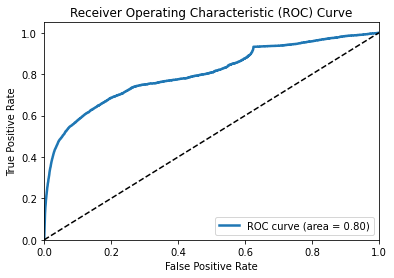

In [89]:
meu.plot_model_roc_curve(clf,x_train,y_train)

### _Metricas de Evaluación (Data de Testeo)_

In [90]:
#Calculando los valores YPredichos
ypredicho_test=clf.predict(x_test)

In [91]:
meu.display_model_performance_metrics(true_labels=y_test,
                                     predicted_labels=ypredicho_test,
                                     classes=label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.9952
Precision: 0.9977
Recall: 0.9952
F1 Score: 0.9964

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906287
           1       0.06      0.19      0.09      2499

    accuracy                           1.00   1908786
   macro avg       0.53      0.59      0.55   1908786
weighted avg       1.00      1.00      1.00   1908786


Prediction Confusion Matrix:
------------------------------
         0     1
0  1899127  7160
1     2031   468


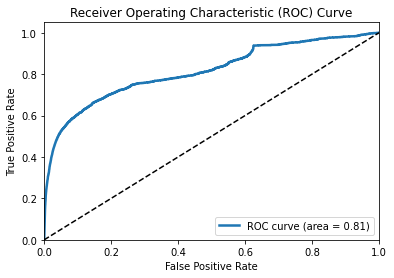

In [92]:
meu.plot_model_roc_curve(clf,x_test,y_test)

### _6. Implementar el modelo de redes neuronales a los datos de entrenamiento._

In [93]:
#Inicializando h2o
h2o.init(max_mem_size='4g')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from C:\ProgramData\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\user\AppData\Local\Temp\tmpst6kda92
  JVM stdout: C:\Users\user\AppData\Local\Temp\tmpst6kda92\h2o_user_started_from_python.out
  JVM stderr: C:\Users\user\AppData\Local\Temp\tmpst6kda92\h2o_user_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Lima
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,1 month and 30 days
H2O_cluster_name:,H2O_from_python_user_5hrghm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [94]:
#Estableciendo nuestro objeto H2OFrame
bank_Redes_Neuronales=h2o.H2OFrame(nueva_bank)
type(bank_Redes_Neuronales)

Parse progress: |█████████████████████████████████████████████████████████| 100%


h2o.frame.H2OFrame

In [95]:
#Estableciendo nuestras etiquetas de la matriz de datos y target
x = bank_Redes_Neuronales.col_names[1:6]### Todos los nombres de las anteriores variables
y = bank_Redes_Neuronales.col_names[6]###La variable Target

In [96]:
#Garantizando que nuestra variable target sea un factor
bank_Redes_Neuronales[y]=bank_Redes_Neuronales[y].asfactor()

In [97]:
#Elaborando el particionamiento de los datos
train,valid, test =bank_Redes_Neuronales.split_frame([0.75, 0.15], 
                                              seed=2020)#Dividir la data de train,valid,test

In [98]:
#Imprimiendo la cantidad de registros para cada partición
print("Cantidad de registros para el Training:", train.nrows)
print("Cantidad de registros para el Validation:", valid.nrows)
print("Cantidad de registros para el Testing:", test.nrows)

Cantidad de registros para el Training: 4772113
Cantidad de registros para el Validation: 954085
Cantidad de registros para el Testing: 636423


- **activation** se refiere a la función de activación que se empleará en cada neurona, que en este caso es el tanh, 
- **hidden** establece la cantidad de capas ocultas así como neuronas en cada una de ellas. En este caso, la red neuronal creada tendrá tres capas ocultas, cada una de ellas con 12 neuronas. 
- **epochs** establece la cantidad de veces que se pasarán los datos de etrenamiento a fin de aplicar el algoritmo de aprendizaje. 

In [99]:
#Instanciando un objeto de clase H20DeepLearningEstimator
m1=H2ODeepLearningEstimator(model_id='modelo1',
                           activation='tanh', #función de activación
                           distribution='multinomial', #distribución de nuestra target
                           hidden=[120,120,120,120,120,120],
                           epochs=500,
                           seed=2020)

In [100]:
#Haciendo que el modelo aprenda de los datos
m1.train(x=x,
        y=y,
        training_frame=train,
        validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [101]:
p_train = m1.predict(train)

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [102]:
p_train

predict,no,si
no,0.999995,4.69374e-06
no,0.999995,5.21127e-06
no,0.999995,5.25105e-06
no,0.999995,5.30562e-06
no,0.999994,5.7983e-06
no,0.999995,5.3926e-06
no,0.999995,5.46881e-06
no,0.999995,5.23291e-06
no,0.999995,5.30383e-06
no,0.999995,5.38704e-06


In [103]:
p_test = m1.predict(test)#Testeo del modelo

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [104]:
p_test#Porcentaje de prediccion

predict,no,si
no,0.999995,4.53782e-06
no,0.999994,5.87135e-06
no,0.999994,5.58242e-06
no,0.999996,3.97387e-06
no,0.999995,5.36458e-06
no,0.999992,7.75459e-06
no,0.999986,1.44206e-05
no,1,3.23795e-07
no,0.999988,1.24092e-05
no,0.999998,2.10072e-06


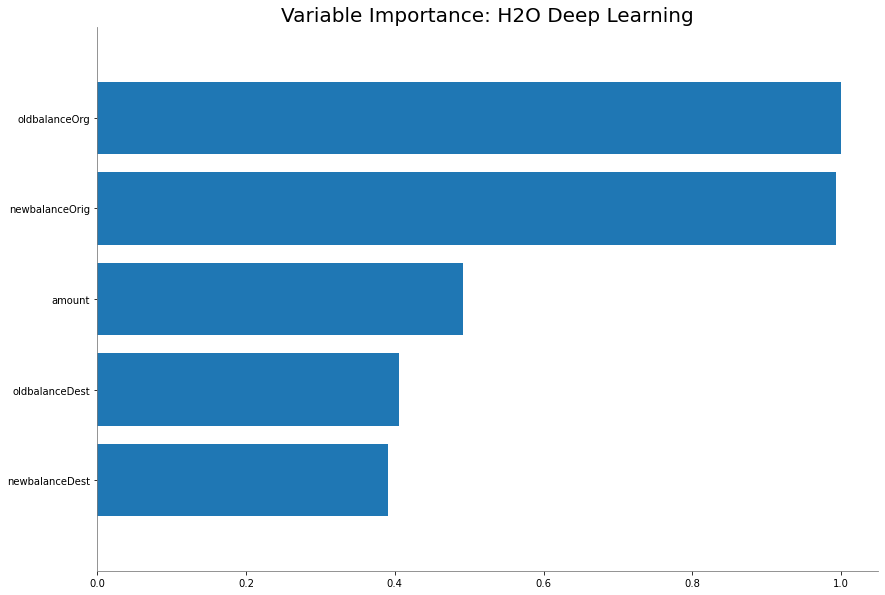

In [105]:
m1.varimp_plot()

In [106]:
#Evaluando la performance del modelo para los datos de entrenamiento
perf_t = m1.model_performance(train)
perf_t


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.0007601148461019505
RMSE: 0.02757018037848049
LogLoss: 0.006885764344374735
Mean Per-Class Error: 0.11741236681560174
AUC: 0.9357855939526083
AUCPR: 0.5402134528519693
Gini: 0.8715711879052166

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24907653781036307: 


,,no,si,Error,Rate
0,no,4765498.0,543.0,0.0001,(543.0/4766041.0)
1,si,3263.0,2809.0,0.5374,(3263.0/6072.0)
2,Total,4768761.0,3352.0,0.0008,(3806.0/4772113.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.249077,5.961375e-01,224.0
1,max f2,0.007868,5.372602e-01,360.0
2,max f0point5,0.973515,7.478230e-01,22.0
3,max accuracy,0.973515,9.992207e-01,22.0
4,max precision,0.999983,9.675465e-01,0.0
5,max recall,0.000002,1.000000e+00,399.0
6,max specificity,0.999983,9.999843e-01,0.0
7,max absolute_mcc,0.874889,6.251726e-01,60.0
8,max min_per_class_accuracy,0.000009,8.774704e-01,397.0
9,max mean_per_class_accuracy,0.000009,8.825876e-01,397.0



Gains/Lift Table: Avg response rate:  0.13 %, avg score:  0.07 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01,5.930495e-05,69.366324,69.366324,0.088261,6.799115e-02,0.088261,0.067991,0.693676,0.693676,6836.632432,6836.632432,0.684547
1,2,0.02,2.483543e-05,6.175906,37.771446,0.007858,3.679362e-05,0.048060,0.034014,0.061759,0.755435,517.590615,3677.144627,0.736372
2,3,0.03,1.698624e-05,3.195002,26.246045,0.004065,2.013812e-05,0.033395,0.022683,0.031950,0.787385,219.500212,2524.604539,0.758350
3,4,0.04,1.410405e-05,1.844537,20.145700,0.002347,1.545857e-05,0.025633,0.017016,0.018445,0.805830,84.453730,1914.570033,0.766806
4,5,0.05,1.200641e-05,1.613970,16.439370,0.002054,1.297840e-05,0.020917,0.013616,0.016140,0.821970,61.397014,1543.936983,0.772953
5,6,0.10,8.090073e-06,1.040842,8.740106,0.001324,9.614818e-06,0.011121,0.006813,0.052042,0.874012,4.084169,774.010576,0.774998
6,7,0.15,6.867746e-06,0.599475,6.026570,0.000763,7.395038e-06,0.007668,0.004544,0.029974,0.903986,-40.052538,502.656963,0.754946
7,8,0.20,6.263957e-06,0.365612,4.611329,0.000465,6.533818e-06,0.005867,0.003410,0.018281,0.922266,-63.438789,361.132877,0.723186
8,9,0.30,5.688342e-06,0.174572,3.132411,0.000222,5.937245e-06,0.003986,0.002275,0.017457,0.939723,-82.542809,213.241085,0.640538
9,10,0.40,5.369041e-06,0.120224,2.379365,0.000153,5.519427e-06,0.003027,0.001708,0.012022,0.951746,-87.977595,137.936454,0.552449


In [107]:
#Evaluando la performance del modelo para los datos de testeo
perf = m1.model_performance(test)
perf


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.0008212242300205765
RMSE: 0.02865701013749649
LogLoss: 0.0075044853771016
Mean Per-Class Error: 0.11940167149339909
AUC: 0.9425364890873975
AUCPR: 0.5390522806237913
Gini: 0.885072978174795

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1790043607061441: 


,,no,si,Error,Rate
0,no,635477.0,80.0,0.0001,(80.0/635557.0)
1,si,462.0,404.0,0.5335,(462.0/866.0)
2,Total,635939.0,484.0,0.0009,(542.0/636423.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,1.790044e-01,0.598519,134.0
1,max f2,4.505144e-03,0.530392,298.0
2,max f0point5,8.807265e-01,0.742915,51.0
3,max accuracy,8.807265e-01,0.999163,51.0
4,max precision,9.999763e-01,0.979167,1.0
5,max recall,3.368113e-07,1.000000,399.0
6,max specificity,9.999924e-01,0.999991,0.0
7,max absolute_mcc,1.863042e-01,0.624062,131.0
8,max min_per_class_accuracy,8.157246e-06,0.869515,390.0
9,max mean_per_class_accuracy,9.629144e-06,0.880598,389.0



Gains/Lift Table: Avg response rate:  0.14 %, avg score:  0.07 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010001,6.139584e-05,68.236548,68.236548,0.092852,7.097163e-02,0.092852,0.070972,0.682448,0.682448,6723.654784,6723.654784,0.673363
1,2,0.020001,2.526563e-05,5.773881,37.007668,0.007857,3.767888e-05,0.050357,0.035507,0.057737,0.740185,477.388072,3600.766784,0.721165
2,3,0.030000,1.712818e-05,3.464328,25.827140,0.004714,2.041288e-05,0.035144,0.023679,0.034642,0.774827,246.432843,2482.714032,0.745841
3,4,0.040000,1.419101e-05,1.501209,19.745896,0.002043,1.556353e-05,0.026869,0.017763,0.015012,0.789838,50.120899,1874.589638,0.750860
4,5,0.050001,1.203154e-05,1.731892,16.142756,0.002357,1.303801e-05,0.021966,0.014213,0.017321,0.807159,73.189208,1514.275587,0.758190
5,6,0.100001,8.110407e-06,0.993076,8.568035,0.001351,9.639508e-06,0.011659,0.007111,0.049654,0.856813,-0.692373,756.803509,0.757843
6,7,0.150001,6.861412e-06,0.577370,5.904508,0.000786,7.395281e-06,0.008034,0.004743,0.028868,0.885681,-42.263007,490.450794,0.736683
7,8,0.200001,6.259604e-06,0.554275,4.566960,0.000754,6.528765e-06,0.006214,0.003559,0.027714,0.913395,-44.572487,356.696024,0.714366
8,9,0.300000,5.688029e-06,0.173211,3.102385,0.000236,5.936208e-06,0.004222,0.002375,0.017321,0.930716,-82.678902,210.238483,0.631575
9,10,0.400000,5.367932e-06,0.161664,2.367207,0.000220,5.518972e-06,0.003221,0.001782,0.016166,0.946882,-83.833642,136.720740,0.547628


In [108]:
#La matriz de confusion para los datos de testeo
perf.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1790043607061441: 


,,no,si,Error,Rate
0,no,635477.0,80.0,0.0001,(80.0/635557.0)
1,si,462.0,404.0,0.5335,(462.0/866.0)
2,Total,635939.0,484.0,0.0009,(542.0/636423.0)


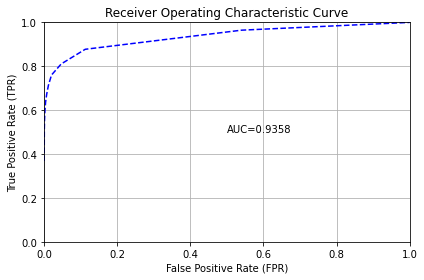

In [109]:
#Graficando la curva ROC para los datos de entrenamiento
perf = m1.model_performance(train)
perf.plot(type = "roc")

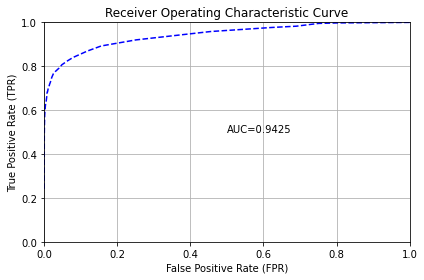

In [110]:
#Graficando la curva ROC para los datos de testeo
perf = m1.model_performance(test)
perf.plot(type = "roc")

In [111]:
h2o.shutdown()

H2O session _sid_8b06 closed.


### _7. haciendo uso de las métricas de accuracy, sensibilidad. especificidad, auc y curva ROC evaluar los modelos generados (train y test) y realizar un análisis._

las metricas estan en los modelos ya mencionados.
Debido aque mi computadora se me paraba lagenado no lo deja hasta ahi pero los codigos estan bien, espero que revicen ese datalle 

**ÁRBOL DE DESICIÓN**

#### _Métricas de evaluación de modelos para datos de entrenamiento y testeo_

In [31]:
probs2 = Arbol_decision.predict(x_test)#datos de testeo
#predict(): función para calcular los valores predichos
probs2

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [32]:
probs = Arbol_decision.predict(x_train_UnderSampler)
#predict(): función para calcular los valores predichos
probs

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [33]:
metrics.accuracy_score(y_test, probs2)

0.9801088230948886

In [34]:
metrics.accuracy_score(y_train_UnderSampler, probs)

0.9585407591785936

In [35]:
from sklearn.metrics import accuracy_score

In [36]:
#Matriz de Confusion para la variablede testeo
matriz=confusion_matrix(y_test,probs2)
print(matriz)

[[1868487   37800]
 [    168    2331]]


In [37]:
#Matriz de Confusion para la variable de entrenamiento
matriz=confusion_matrix(y_train_UnderSampler, probs)
print(matriz)

[[7012  130]
 [ 403 5311]]


In [38]:
#TESTEO
accuracy=accuracy_score(y_test,probs2)
print(accuracy)

0.9801088230948886


In [39]:
score= cross_val_score(Arbol_decision, #estimator
                      x_train_UnderSampler,
                      y_train_UnderSampler,
                      scoring='accuracy', #Métrica o estrategia de evaluación
                      cv=10) #Número de Particiones para la evaluación
score

array([0.94867807, 0.96345257, 0.95178849, 0.95412131, 0.96189736,
       0.95956454, 0.95252918, 0.9618677 , 0.96575875, 0.96031128])

In [40]:
score.mean()

0.9579969258884968

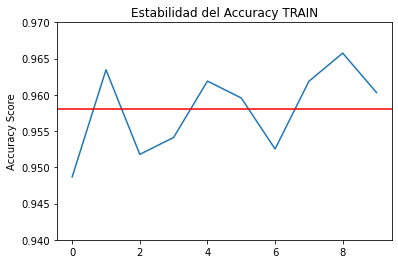

In [41]:
#Analizando visualmente la estabilidad de la métrica
plt.plot(range(0,10),score)
plt.title('Estabilidad del Accuracy TRAIN')
plt.ylabel('Accuracy Score')
plt.axhline(y=score.mean(),color="red") #Línea referencial
plt.ylim([0.94,0.97]) #Modificando los límites del eje Y
plt.show()

In [42]:
score= cross_val_score(Arbol_decision, #estimator
                      x_test,
                      y_test,
                      scoring='accuracy', #Métrica o estrategia de evaluación
                      cv=10) #Número de Particiones para la evaluación
score

array([0.9995285 , 0.99955469, 0.99929798, 0.99929275, 0.99955993,
       0.99921416, 0.99930846, 0.99934513, 0.99936609, 0.99939752])

In [43]:
score.mean()

0.999386520998747

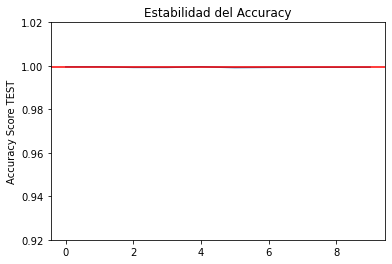

In [44]:
#Analizando visualmente la estabilidad de la métrica
plt.plot(range(0,10),score)
plt.title('Estabilidad del Accuracy')
plt.ylabel('Accuracy Score TEST')
plt.axhline(y=score.mean(),color="red") #Línea referencial
plt.ylim([0.92,1.02]) #Modificando los límites del eje Y
plt.show()

**RANDOM FORES**

In [58]:
#Evaluar la performance del modelo con los datos de entrenamiento
performance_train= m.model_performance(bank_h2o_train)
performance_train


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.0009681565794545058
RMSE: 0.031115214597596877
LogLoss: 0.005451271948523809
Mean Per-Class Error: 0.09056122101047093
AUC: 0.9564375486672004
AUCPR: 0.5156335764071227
Gini: 0.9128750973344009

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08258996438980101: 


,,no,si,Error,Rate
0,no,6353409.0,999.0,0.0002,(999.0/6354408.0)
1,si,5049.0,3164.0,0.6148,(5049.0/8213.0)
2,Total,6358458.0,4163.0,0.001,(6048.0/6362621.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.082590,5.113122e-01,140.0
1,max f2,0.021050,6.062820e-01,216.0
2,max f0point5,0.178425,6.940663e-01,88.0
3,max accuracy,0.140405,9.991184e-01,103.0
4,max precision,0.785283,1.000000e+00,0.0
5,max recall,0.000594,1.000000e+00,378.0
6,max specificity,0.785283,1.000000e+00,0.0
7,max absolute_mcc,0.140405,5.647902e-01,103.0
8,max min_per_class_accuracy,0.002892,8.793376e-01,321.0
9,max mean_per_class_accuracy,0.002892,9.094388e-01,321.0



Gains/Lift Table: Avg response rate:  0.13 %, avg score:  0.13 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010032,0.006523,74.204120,74.204120,0.095784,0.036316,0.095784,0.036316,0.744430,0.744430,7320.411978,7320.411978,0.735347
1,2,0.020441,0.005734,0.081882,36.459961,0.000106,0.005878,0.047063,0.020816,0.000852,0.745282,-91.811759,3545.996108,0.725778
2,3,0.030277,0.005181,0.012379,24.619222,0.000016,0.005416,0.031779,0.015813,0.000122,0.745404,-98.762142,2361.922198,0.716051
3,4,0.040427,0.004004,0.035987,18.447131,0.000046,0.004481,0.023812,0.012968,0.000365,0.745769,-96.401258,1744.713123,0.706253
4,5,0.051703,0.003069,9.384100,16.470678,0.012113,0.003245,0.021261,0.010848,0.105808,0.851577,838.410019,1547.067834,0.800908
5,6,0.103861,0.001893,0.532242,8.466488,0.000687,0.002382,0.010929,0.006596,0.027761,0.879338,-46.775825,746.648766,0.776479
6,7,0.151781,0.001072,0.002541,5.794259,0.000003,0.001262,0.007479,0.004912,0.000122,0.879459,-99.745915,479.425925,0.728619
7,8,0.207155,0.000941,0.094550,4.270693,0.000122,0.000997,0.005513,0.003866,0.005236,0.884695,-90.544970,327.069345,0.678416
8,9,0.305449,0.000767,0.566089,3.078541,0.000731,0.000836,0.003974,0.002891,0.055643,0.940338,-43.391074,207.854059,0.635710
9,10,0.423321,0.000726,0.342946,2.316827,0.000443,0.000737,0.002991,0.002291,0.040424,0.980762,-65.705371,131.682697,0.558161


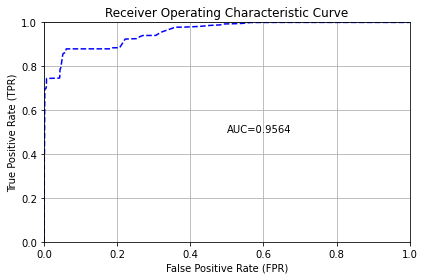

In [59]:
#Podemos obtener la curva ROC para la Data de Entrenamiento con su respectivo AUC
performance_train.plot(type='roc')

In [60]:
#Podemos obtener la Matriz de Confusión para la Data de Entrenamiento
performance_train.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08258996438980101: 


,,no,si,Error,Rate
0,no,6353409.0,999.0,0.0002,(999.0/6354408.0)
1,si,5049.0,3164.0,0.6148,(5049.0/8213.0)
2,Total,6358458.0,4163.0,0.001,(6048.0/6362621.0)


#### Hallando las probabilidades de Ypredicho

In [61]:
#Cálculo de probabilidades de predicción para la variable target (Data de Entrenamiento)
ypredicho_train=m.predict(bank_h2o_train)
ypredicho_train

drf prediction progress: |████████████████████████████████████████████████| 100%


predict,no,si
no,0.997772,0.00222771
no,0.999566,0.000433656
no,0.978958,0.0210416
no,0.999293,0.00070721
no,0.999406,0.000594434
no,0.999406,0.000594434
no,0.998107,0.00189279
no,0.997772,0.00222771
no,0.999421,0.000579426
no,0.999387,0.000613041


In [62]:
type(ypredicho_train)

h2o.frame.H2OFrame

In [63]:
#Convertir un objeto h2oFrame en un DataFrame de Pandas
ypredicho_train_pandas=h2o.as_list(ypredicho_train)
ypredicho_train_pandas.head()

,predict,no,si
0,no,0.997772,0.002228
1,no,0.999566,0.000434
2,no,0.978958,0.021042
3,no,0.999293,0.000707
4,no,0.999406,0.000594


In [64]:
type(ypredicho_train_pandas)

pandas.core.frame.DataFrame

In [65]:
len(ypredicho_train_pandas)

6362621

**NAIVE BAYES**

### _Entrenamiento del Modelo_

In [84]:
#Instanciando un objeto de clase GaussianNB
clf= GaussianNB()

In [85]:
#Aprendiendo de los datos de entrenamiento
clf.fit(x_train,y_train)

GaussianNB()

In [86]:
#Establecemos los nombres de etiquetas
label_names=[0,1]

In [87]:
#Calculando los valores YPredichos
ypredicho_train=clf.predict(x_train)

### _Metricas de Evaluación (Data de Entrenamiento)_

In [88]:
meu.display_model_performance_metrics(true_labels=y_train,
                                     predicted_labels=ypredicho_train,
                                     classes=label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.9951
Precision: 0.9977
Recall: 0.9951
F1 Score: 0.9964

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4448120
           1       0.05      0.16      0.08      5714

    accuracy                           1.00   4453834
   macro avg       0.53      0.58      0.54   4453834
weighted avg       1.00      1.00      1.00   4453834


Prediction Confusion Matrix:
------------------------------
         0      1
0  4431237  16883
1     4785    929


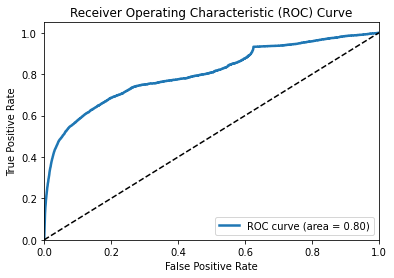

In [89]:
meu.plot_model_roc_curve(clf,x_train,y_train)

### _Metricas de Evaluación (Data de Testeo)_

In [90]:
#Calculando los valores YPredichos
ypredicho_test=clf.predict(x_test)

In [91]:
meu.display_model_performance_metrics(true_labels=y_test,
                                     predicted_labels=ypredicho_test,
                                     classes=label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.9952
Precision: 0.9977
Recall: 0.9952
F1 Score: 0.9964

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906287
           1       0.06      0.19      0.09      2499

    accuracy                           1.00   1908786
   macro avg       0.53      0.59      0.55   1908786
weighted avg       1.00      1.00      1.00   1908786


Prediction Confusion Matrix:
------------------------------
         0     1
0  1899127  7160
1     2031   468


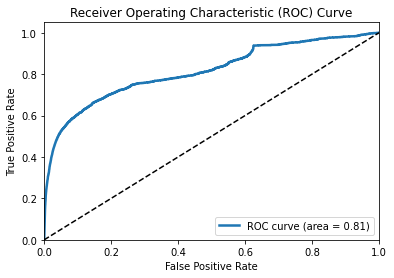

In [92]:
meu.plot_model_roc_curve(clf,x_test,y_test)

**REDES NEURONALES**

In [106]:
#Evaluando la performance del modelo para los datos de entrenamiento
perf_t = m1.model_performance(train)
perf_t


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.0007601148461019505
RMSE: 0.02757018037848049
LogLoss: 0.006885764344374735
Mean Per-Class Error: 0.11741236681560174
AUC: 0.9357855939526083
AUCPR: 0.5402134528519693
Gini: 0.8715711879052166

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24907653781036307: 


,,no,si,Error,Rate
0,no,4765498.0,543.0,0.0001,(543.0/4766041.0)
1,si,3263.0,2809.0,0.5374,(3263.0/6072.0)
2,Total,4768761.0,3352.0,0.0008,(3806.0/4772113.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.249077,5.961375e-01,224.0
1,max f2,0.007868,5.372602e-01,360.0
2,max f0point5,0.973515,7.478230e-01,22.0
3,max accuracy,0.973515,9.992207e-01,22.0
4,max precision,0.999983,9.675465e-01,0.0
5,max recall,0.000002,1.000000e+00,399.0
6,max specificity,0.999983,9.999843e-01,0.0
7,max absolute_mcc,0.874889,6.251726e-01,60.0
8,max min_per_class_accuracy,0.000009,8.774704e-01,397.0
9,max mean_per_class_accuracy,0.000009,8.825876e-01,397.0



Gains/Lift Table: Avg response rate:  0.13 %, avg score:  0.07 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01,5.930495e-05,69.366324,69.366324,0.088261,6.799115e-02,0.088261,0.067991,0.693676,0.693676,6836.632432,6836.632432,0.684547
1,2,0.02,2.483543e-05,6.175906,37.771446,0.007858,3.679362e-05,0.048060,0.034014,0.061759,0.755435,517.590615,3677.144627,0.736372
2,3,0.03,1.698624e-05,3.195002,26.246045,0.004065,2.013812e-05,0.033395,0.022683,0.031950,0.787385,219.500212,2524.604539,0.758350
3,4,0.04,1.410405e-05,1.844537,20.145700,0.002347,1.545857e-05,0.025633,0.017016,0.018445,0.805830,84.453730,1914.570033,0.766806
4,5,0.05,1.200641e-05,1.613970,16.439370,0.002054,1.297840e-05,0.020917,0.013616,0.016140,0.821970,61.397014,1543.936983,0.772953
5,6,0.10,8.090073e-06,1.040842,8.740106,0.001324,9.614818e-06,0.011121,0.006813,0.052042,0.874012,4.084169,774.010576,0.774998
6,7,0.15,6.867746e-06,0.599475,6.026570,0.000763,7.395038e-06,0.007668,0.004544,0.029974,0.903986,-40.052538,502.656963,0.754946
7,8,0.20,6.263957e-06,0.365612,4.611329,0.000465,6.533818e-06,0.005867,0.003410,0.018281,0.922266,-63.438789,361.132877,0.723186
8,9,0.30,5.688342e-06,0.174572,3.132411,0.000222,5.937245e-06,0.003986,0.002275,0.017457,0.939723,-82.542809,213.241085,0.640538
9,10,0.40,5.369041e-06,0.120224,2.379365,0.000153,5.519427e-06,0.003027,0.001708,0.012022,0.951746,-87.977595,137.936454,0.552449


In [107]:
#Evaluando la performance del modelo para los datos de testeo
perf = m1.model_performance(test)
perf


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.0008212242300205765
RMSE: 0.02865701013749649
LogLoss: 0.0075044853771016
Mean Per-Class Error: 0.11940167149339909
AUC: 0.9425364890873975
AUCPR: 0.5390522806237913
Gini: 0.885072978174795

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1790043607061441: 


,,no,si,Error,Rate
0,no,635477.0,80.0,0.0001,(80.0/635557.0)
1,si,462.0,404.0,0.5335,(462.0/866.0)
2,Total,635939.0,484.0,0.0009,(542.0/636423.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,1.790044e-01,0.598519,134.0
1,max f2,4.505144e-03,0.530392,298.0
2,max f0point5,8.807265e-01,0.742915,51.0
3,max accuracy,8.807265e-01,0.999163,51.0
4,max precision,9.999763e-01,0.979167,1.0
5,max recall,3.368113e-07,1.000000,399.0
6,max specificity,9.999924e-01,0.999991,0.0
7,max absolute_mcc,1.863042e-01,0.624062,131.0
8,max min_per_class_accuracy,8.157246e-06,0.869515,390.0
9,max mean_per_class_accuracy,9.629144e-06,0.880598,389.0



Gains/Lift Table: Avg response rate:  0.14 %, avg score:  0.07 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010001,6.139584e-05,68.236548,68.236548,0.092852,7.097163e-02,0.092852,0.070972,0.682448,0.682448,6723.654784,6723.654784,0.673363
1,2,0.020001,2.526563e-05,5.773881,37.007668,0.007857,3.767888e-05,0.050357,0.035507,0.057737,0.740185,477.388072,3600.766784,0.721165
2,3,0.030000,1.712818e-05,3.464328,25.827140,0.004714,2.041288e-05,0.035144,0.023679,0.034642,0.774827,246.432843,2482.714032,0.745841
3,4,0.040000,1.419101e-05,1.501209,19.745896,0.002043,1.556353e-05,0.026869,0.017763,0.015012,0.789838,50.120899,1874.589638,0.750860
4,5,0.050001,1.203154e-05,1.731892,16.142756,0.002357,1.303801e-05,0.021966,0.014213,0.017321,0.807159,73.189208,1514.275587,0.758190
5,6,0.100001,8.110407e-06,0.993076,8.568035,0.001351,9.639508e-06,0.011659,0.007111,0.049654,0.856813,-0.692373,756.803509,0.757843
6,7,0.150001,6.861412e-06,0.577370,5.904508,0.000786,7.395281e-06,0.008034,0.004743,0.028868,0.885681,-42.263007,490.450794,0.736683
7,8,0.200001,6.259604e-06,0.554275,4.566960,0.000754,6.528765e-06,0.006214,0.003559,0.027714,0.913395,-44.572487,356.696024,0.714366
8,9,0.300000,5.688029e-06,0.173211,3.102385,0.000236,5.936208e-06,0.004222,0.002375,0.017321,0.930716,-82.678902,210.238483,0.631575
9,10,0.400000,5.367932e-06,0.161664,2.367207,0.000220,5.518972e-06,0.003221,0.001782,0.016166,0.946882,-83.833642,136.720740,0.547628


In [108]:
#La matriz de confusion para los datos de testeo
perf.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1790043607061441: 


,,no,si,Error,Rate
0,no,635477.0,80.0,0.0001,(80.0/635557.0)
1,si,462.0,404.0,0.5335,(462.0/866.0)
2,Total,635939.0,484.0,0.0009,(542.0/636423.0)


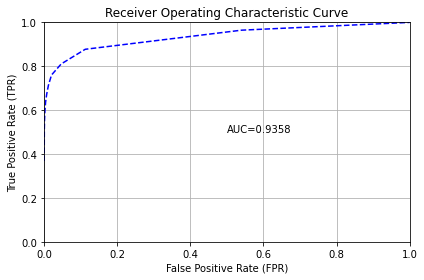

In [109]:
#Graficando la curva ROC para los datos de entrenamiento
perf = m1.model_performance(train)
perf.plot(type = "roc")

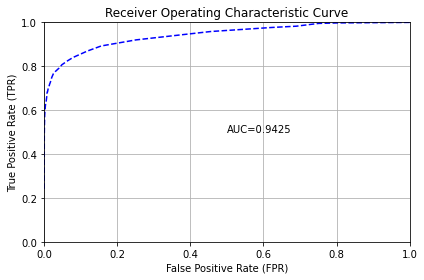

In [110]:
#Graficando la curva ROC para los datos de testeo
perf = m1.model_performance(test)
perf.plot(type = "roc")

### _8. Desplegar el modelo haciendo uso de H2O mediante Dash._ 

In [2]:
#Cambiando mi directorio de trabajo
os.chdir(r"E:\PYTHON\MODULO 3-AVANZADO\EXAMEN FINAL")

In [3]:
#Importando el archivo de trabajo
FileCSV="PS_20174392719_1491204439457_log.csv"
df_bank=pd.read_csv(FileCSV,sep=",")
df_bank.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
#Veamos la informacion de nuestra data
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
#Elinando las columna que no vamos a trabajar
columnas=['step', 'nameOrig', 'nameDest', 'isFlaggedFraud']
nueva_bank_1=df_bank.drop(columnas,axis=1)
nueva_bank_1.head(5)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [6]:
#Transfotmamos la columna "type" de tipo objeto a entero
encoder = LabelEncoder()
nueva_bank_1["type"] = encoder.fit_transform(nueva_bank_1["type"])

In [7]:
pd.value_counts(nueva_bank_1.type)

1    2237500
3    2151495
0    1399284
4     532909
2      41432
Name: type, dtype: int64

In [8]:
print('Las variables transformadas se almacenan en los siguientes valores')
print('...............A) CASH_IN  = 0...............')
print('...............B) CASH_OUT = 1...............')
print('...............C) DEBIT    = 2...............')
print('...............D) PAYMENT  = 3...............')
print('...............E) TRANSFER = 4...............')

Las variables transformadas se almacenan en los siguientes valores
...............A) CASH_IN  = 0...............
...............B) CASH_OUT = 1...............
...............C) DEBIT    = 2...............
...............D) PAYMENT  = 3...............
...............E) TRANSFER = 4...............


In [9]:
#Mostramos los datos transformados
nueva_bank_1.head(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,3,9839.64,170136.00,160296.36,0.0,0.00,0
1,3,1864.28,21249.00,19384.72,0.0,0.00,0
2,4,181.00,181.00,0.00,0.0,0.00,1
3,1,181.00,181.00,0.00,21182.0,0.00,1
4,3,11668.14,41554.00,29885.86,0.0,0.00,0
5,3,7817.71,53860.00,46042.29,0.0,0.00,0
6,3,7107.77,183195.00,176087.23,0.0,0.00,0
7,3,7861.64,176087.23,168225.59,0.0,0.00,0
8,3,4024.36,2671.00,0.00,0.0,0.00,0
9,2,5337.77,41720.00,36382.23,41898.0,40348.79,0


In [10]:
#Dividimos la variables de entrenamiento y nuestra Target
x = nueva_bank_1.drop(columns="isFraud")
y = nueva_bank_1["isFraud"]

In [11]:
#Particionamos nuestros datos
x_train_final, x_test_final, y_train_final, y_test_final = train_test_split(x, y, test_size=0.3, random_state=2020)

In [12]:
print('La cantidad de filas de la data de entrenamiento(x_train) es: ',len(x_train_final))
print('La cantidad de filas de la data de testeo(x_test) es: ',len(x_test_final))

La cantidad de filas de la data de entrenamiento(x_train) es:  4453834
La cantidad de filas de la data de testeo(x_test) es:  1908786


In [13]:
#Hacemos el balanceo de los datos usando UnderSampler
UnderSampler_final=RandomUnderSampler(sampling_strategy=0.8,random_state=2020)
x_train_US,y_train_US=UnderSampler_final.fit_resample(x_train_final,y_train_final)

In [14]:
#Creando una instancia del tipo DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf.fit(x_train_US, y_train_US)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [15]:
#entrenamiento 
clf.score(x_train_US,y_train_US)

0.9429060360920971

In [16]:
#prueba / test
clf.score(x_test_final,y_test_final)

0.9547293410576146

**Despliegue del modelo**

In [17]:
import dash
import dash_core_components as dcc
import dash_html_components as dhc
import dash_bootstrap_components as dbc
from dash.dependencies import Output, Input, State
from joblib import load

In [18]:
#Cambiando mi directorio de trabajo
os.chdir(r"E:\PYTHON\MODULO 3-AVANZADO\EXAMEN FINAL\MODELO")

In [19]:
#Vertiendo el modelo a una extensión .joblib
dump(clf,'Modelo_bank.joblib') 

['Modelo_bank.joblib']

In [20]:
dump(encoder, 'label_encoder.joblib')

['label_encoder.joblib']

In [21]:
model_loaded = load('Modelo_bank.joblib')
model_loaded.predict(x_test_final)

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [22]:
encoder_loaded = load('label_encoder.joblib')
type(encoder_loaded)

sklearn.preprocessing._label.LabelEncoder

In [23]:
nueva_bank_1.head(1)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,3,9839.64,170136.0,160296.36,0.0,0.0,0


In [24]:
#Creando un diccionario
d = {'type': [3], 'amount': [9839.64],'oldbalanceOrg': [170136], 'newbalanceOrig': [160296.36],
     'oldbalanceDest': [0], 'newbalanceDest': [0]}
df = pd.DataFrame(data=d)

In [25]:
#Mostrando el dataframe df
df

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,3,9839.64,170136,160296.36,0,0


In [26]:
#Precedimos la categoría del modelo
clf.predict(df)[0]

0

In [27]:
#Mostramos las probabilidades de las clases
clf.predict_proba(df)[0]

array([0.9980139, 0.0019861])

In [28]:
probabilidad=clf.predict_proba(df)[0]
if probabilidad[0] < 0.5:
      salida="FRAUDE"
      probabilidad2=probabilidad[1]
else:
    probabilidad2=probabilidad[0]
    salida="No FRAUDE"
print(salida)
print(probabilidad)
print('La predicción fue de clase', salida, 'con una probabilidad de '+str(round(float(probabilidad2),2)))

No FRAUDE
[0.9980139 0.0019861]
La predicción fue de clase No FRAUDE con una probabilidad de 1.0
